# Initialize the accelerator
### This file is meant to be run on the FPGA

### Remember to install the following dependencies:

In [1]:
# ! apt-get update -y
# ! apt-get install libhdf5-dev -y
# ! pip3 install versioned-hdf5

In [1]:
!export XILINX_XRT=/usr

from finn_examples import models
print(list(filter(lambda x: "radioml" in x, dir(models)))) 

['_radioml_io_shape_dict', 'vgg10_w4a4_radioml']


In [2]:
# Note: the RadioML example is only available on the ZCU104 at the moment
import pynq
target_platform="ZCU104"
# accel = models.vgg10_w4a4_radioml()

from driver import io_shape_dict
from driver_base import FINNExampleOverlay

accel=  FINNExampleOverlay(
        bitfile_name="finn-accel.bit",
        platform="zynq-iodma",
        io_shape_dict=io_shape_dict,
        batch_size=1,
        runtime_weight_dir="runtime_weights/",
        fclk_mhz=250.0
    )   

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal()), str(accel.idt())))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal()), str(accel.odt())))

Expected input shape and datatype: (1, 1024, 1, 2) INT8
Expected output shape and datatype: (1, 1) UINT8


# Load RadioML 2021 dataset

Please note that you will have to manually download the RadioML 2018 dataset and set the `dataset_dir` variable to point to its path.

In [ ]:
import numpy as np
import math
import pickle
import os
import h5py

#Change this to your dataset directory
os.environ["RADIOML_PATH"]="/dataset/" 
dataset_dir = os.environ["RADIOML_PATH"]
print(dataset_dir)

In [20]:
h5_file = h5py.File(dataset_dir + "/RADIOML_2021_07_INT8.hdf5",'r')
data_h5 = h5_file['X']
label_mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
label_snr = h5_file['Z'][:,0]

# assemble list of test set indices
# do not pre-load large dataset into memory
np.random.seed(2021)
test_indices = []
for mod in range(0, 27): #all modulations (0 to 26)
    for snr_idx in range(0, 26): #all SNRs (0 to 25 = -20dB to +30dB)
        start_idx = 26*4096*mod + 4096*snr_idx
        indices_subclass = list(range(start_idx, start_idx+4096))

        split = int(np.ceil(0.1 * 4096)) #90%/10% split
        np.random.shuffle(indices_subclass)
        train_indices_subclass, val_indices_subclass = indices_subclass[split:], indices_subclass[:split]

        #Lower bound of SNR included in test set.
        # >=0 means all SNRs,
        # >=25 means only 30db.
        #Note that SNRS is from -20 to +30 with steps of 2
        if snr_idx >= 25: #select which SNRs to test on 
            test_indices.extend(val_indices_subclass)

test_indices = sorted(test_indices)

# note: labels given in the "classes.txt" file are not in the correct order (https://github.com/radioML/dataset/issues/25)
mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

In [21]:
print(data_h5.shape)
print(label_mod.shape)
print(label_snr.shape)
print(len(test_indices))

(2875392, 1024, 2)
(2875392,)
(2875392,)
287820


# Inspect a single frame

Modulation: 16QAM, SNR: 30.0 dB


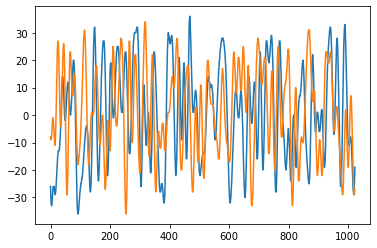

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

# Inspect a frame
mod = 12 # 0 to 26
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = data_h5[idx], label_mod[idx], label_snr[idx]
plt.figure()
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

# Input quantization
Quantize input data on-the-fly in software before feeding it to the accelerator. Use the uniform quantization range on which the model was trained.

In [12]:
def quantize(data):
    # quant_min = -128.0
    # quant_max = 127
    # quant_range = quant_max - quant_min
    # data_quant = (data - quant_min) / quant_range
    # data_quant = np.round(data_quant * 256) - 128
    # data_quant = np.clip(data_quant, -128, 127)
    data_quant=data
    data_quant = data_quant.astype(np.int8)
    return data_quant

# Classify a single frame

In [13]:
accel_in = quantize(data).reshape(accel.ishape_normal())
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 1024, 1, 2) and datatype is int8


In [14]:
accel_out = accel.execute(accel_in)

In [15]:
print("Result: " + str(accel_out))
print("Top-1 class predicted by the accelerator: " + mod_classes[int(accel_out)])

Result: [[12.]]
Top-1 class predicted by the accelerator: 16QAM


In [13]:
%%timeit
accel_out = accel.execute(accel_in)

1.5 ms ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Validate accuracy on entire test set

In [22]:
batch_size = 1024
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed()), str(accel.oshape_packed())))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_folded()), str(accel.oshape_folded())))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_normal()), str(accel.oshape_normal())))

Accelerator buffer shapes are (1024, 1024, 1, 1, 2) for input, (1024, 1, 1) for output
Accelerator buffer shapes are (1024, 1024, 1, 1, 2) for input, (1024, 1, 1) for output
Accelerator buffer shapes are (1024, 1024, 1, 2) for input, (1024, 1) for output


In [23]:
import time
ok = 0
nok = 0
total = len(test_indices)
timer=0
for i_batch in range(math.ceil(total/batch_size)):
    i_frame = i_batch*batch_size
    if i_frame+batch_size > total:
        batch_size = total - i_frame
        accel.batch_size = batch_size
    batch_indices = test_indices[i_frame:i_frame+batch_size]
    data, mod, snr = data_h5[batch_indices], label_mod[batch_indices], label_snr[batch_indices]
    
    ibuf = quantize(data).reshape(accel.ishape_normal())
    
    start_time=time.time()
    obuf = accel.execute(ibuf)
    batch_time=time.time()-start_time
    timer+=batch_time
    
    pred = obuf.reshape(batch_size).astype(int)

    ok += np.equal(pred, mod).sum().item()
    nok += np.not_equal(pred, mod).sum().item()
    
    print("batch %d : total OK %d | NOK %d | Time: %.2f seconds" % (i_batch, ok, nok, batch_time))
    
print('total time: ',timer,' seconds')

batch 0 : total OK 35 | NOK 989 | Time: 0.42 seconds
batch 1 : total OK 126 | NOK 1922 | Time: 0.42 seconds
batch 2 : total OK 660 | NOK 2412 | Time: 0.42 seconds
batch 3 : total OK 1587 | NOK 2509 | Time: 0.42 seconds
batch 4 : total OK 2609 | NOK 2511 | Time: 0.42 seconds
batch 5 : total OK 3633 | NOK 2511 | Time: 0.42 seconds
batch 6 : total OK 4657 | NOK 2511 | Time: 0.42 seconds
batch 7 : total OK 5681 | NOK 2511 | Time: 0.42 seconds
batch 8 : total OK 6705 | NOK 2511 | Time: 0.42 seconds
batch 9 : total OK 7729 | NOK 2511 | Time: 0.42 seconds
batch 10 : total OK 8167 | NOK 3097 | Time: 0.42 seconds
batch 11 : total OK 8193 | NOK 4095 | Time: 0.42 seconds
batch 12 : total OK 8288 | NOK 5024 | Time: 0.42 seconds
batch 13 : total OK 8534 | NOK 5802 | Time: 0.42 seconds
batch 14 : total OK 9280 | NOK 6080 | Time: 0.42 seconds
batch 15 : total OK 10223 | NOK 6161 | Time: 0.42 seconds
batch 16 : total OK 11245 | NOK 6163 | Time: 0.42 seconds
batch 17 : total OK 12268 | NOK 6164 | Time:

In [24]:
acc = 100.0 * ok / (total)
print("Overall top-1 accuracy: {}%".format(acc))

Overall top-1 accuracy: 61.57390035438816%


## More benchmarking

In [19]:
accel.batch_size = 1024
accel.throughput_test()

{'runtime[ms]': 420.3033447265625,
 'throughput[images/s]': 2436.3355962969686,
 'DRAM_in_bandwidth[MB/s]': 4.989615301216191,
 'DRAM_out_bandwidth[MB/s]': 0.0024363355962969684,
 'fclk[mhz]': 249.9975,
 'batch_size': 1024,
 'fold_input[ms]': 0.0896453857421875,
 'pack_input[ms]': 0.0667572021484375,
 'copy_input_data_to_device[ms]': 2.5424957275390625,
 'copy_output_data_from_device[ms]': 0.1270771026611328,
 'unpack_output[ms]': 0.5090236663818359,
 'unfold_output[ms]': 0.064849853515625}